# Import libraries

In [1]:
import pandas as pd
import time
import numpy as np

import seaborn as sns
sns.set(style="darkgrid", rc = {'figure.figsize':(5,7)})

from hyperopt import fmin, space_eval, tpe, hp
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.linear_model import ElasticNet
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold, cross_val_score, train_test_split, RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from statsmodels.tools.eval_measures import rmse
from xgboost import XGBRegressor

import pickle
import shap

# Define parameters

In [2]:
# Main path
root_path = r"C:\Users\Sonita\Documents\KU_Leuven\Subjects\2022-1\Modern Data Analytics\5. New_Project\github"

# Path for data
data_path = root_path + r"\data"

# Path for codes
code_path = root_path + r"\code"

# Path for models
models_path = root_path + r"\models"

# Path for outputs
output_path = root_path + r"\output"

# Define random state for reproducibility
random_state = 0

# Define folds for fine tuning
num_folds = 5

# Set flag to train or load model
# To load the model then: load_model = True
# To train the model then: load_model = False
load_model = True

# Define colors to use in plots
colors = ["#00cfcc","#e6013b","#007f88","#00cccd","#69e0da","darkblue"]

# Read data

In [3]:
start_time = time.time()

# Read processed data
filt_whole_df = pd.read_csv(output_path + "\\" + "4.filt_year_processed_df.csv", sep=";", encoding="latin1")

print("Execution time:", time.time() - start_time, " seconds")

Execution time: 0.03199625015258789  seconds


# Models

## Select and split data for models

In [4]:
# Get list with all analyzable variables
all_vars = filt_whole_df.columns
all_vars = [i for i in all_vars if i not in ['Year', 'Country_code', 'Country'
                                             , 'Country_code3', 'suicide_rate_est', 'suicide_rate_low'
                                             , 'suicide_rate_high', 'suicide_rate_est_MEN', 'suicide_rate_low_MEN'
                                             , 'suicide_rate_high_MEN', 'suicide_rate_est_WMEN', 'suicide_rate_low_WMEN'
                                             , 'suicide_rate_high_WMEN', 'Country_cross']]

# Select data to use for modeling
X = filt_whole_df[all_vars]
y = filt_whole_df['suicide_rate_est']

print("X shape:",X.shape)
print("Y shape:",y.shape)
print("======================================================================================")

# Divide data in train and an auxiliar for validation/test randomly, taking the train size as 70% of the whole data
x_train_glob, x_test_glob, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = random_state)

# Divide auxiliar data in valdiation/train randomly, taking the validation and train size as 15% (for each) of the whole data
x_val_glob, x_test_glob, y_val, y_test = train_test_split(x_test_glob, y_test, test_size = 0.5, random_state = random_state)

print("X Train shape:",x_train_glob.shape)
print("Y Train shape:",y_train.shape)
print("X Validation shape:",x_val_glob.shape)
print("Y Validation shape:",y_val.shape)
print("X Test shape:",x_test_glob.shape)
print("Y Test shape:",y_test.shape)

# K-Folds cross-validator
kf = KFold(n_splits=num_folds, random_state=random_state, shuffle=True)

X shape: (560, 161)
Y shape: (560,)
X Train shape: (392, 161)
Y Train shape: (392,)
X Validation shape: (84, 161)
Y Validation shape: (84,)
X Test shape: (84, 161)
Y Test shape: (84,)


## XG-Boost fitting

In [5]:
# vars_selected = all_vars
vars_selected = ['Num-Pre-Bot-Non_ski_can','Per-YLD-Bot-Mus_dis','Rat-Dea-Bot-Sub_use_dis','Rat-YLD-Bot-Dig_dis','Min_temperature','Rat-Dea-Bot-Chr_res_dis','Per-Pre-Bot-Chr_res_dis','Num-Pre-Bot-Mus_dis','Per-Dea-Bot-Chr_res_dis','Rat-YLD-Bot-Non_ski_can','Rat-Pre-Bot-Sub_use_dis','Rat-YLD-Bot-Men_dis','Per-YLD-Bot-Chr_res_dis']

# Select variables
x_train = x_train_glob[vars_selected]
x_val = x_val_glob[vars_selected]
x_test = x_test_glob[vars_selected]

print("======================================================================================")
print("X Train shape:",x_train.shape)
print("Y Train shape:",y_train.shape)
print("X Validation shape:",x_val.shape)
print("Y Validation shape:",y_val.shape)
print("X Test shape:",x_test.shape)
print("Y Test shape:",y_test.shape)

X Train shape: (392, 13)
Y Train shape: (392,)
X Validation shape: (84, 13)
Y Validation shape: (84,)
X Test shape: (84, 13)
Y Test shape: (84,)


In [6]:
start_time = time.time()

# Hyperparameter optimization
if load_model:
  # Load model
  infile = open(models_path + "\\" + 'XGboost_model.pkl','rb')
  xgb_grid = pickle.load(infile)

  # Load best parameters
  infile = open(models_path + "\\" + 'best_params_XGboost.pkl','rb')
  best_params = pickle.load(infile)
else:
  # Define function to minimize
  def param_selection_cv(params, random_state=random_state, cv=kf, X=x_train, y=y_train):

      # Use params to create new model
      model = make_pipeline( XGBRegressor(objective="reg:squarederror", random_state = random_state, **params))

      # Do cross validation with the same folds
      score = -cross_val_score(model, X, y, cv=cv, scoring="neg_root_mean_squared_error", n_jobs = -1,error_score = 'raise').mean()

      return score

  # Define grid (space)
  parameters = {'max_depth': hp.choice('max_depth', range(3,10,1))
        , 'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1)
        , 'n_estimators': hp.choice('n_estimators', [50, 100, 300])
        , 'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1)
        , 'reg_alpha' : hp.quniform('reg_alpha', 0,1,1)
    }

  # Minimize function
  best = fmin(fn = param_selection_cv
            , space = parameters
            , algo = tpe.suggest
            , max_evals = 10
            , rstate = np.random.RandomState(random_state)
          )

  # Retrieve best hyperparameters
  best_params = space_eval(parameters, best)

  # Define model with best hyperparameters
  xgb_grid = make_pipeline( XGBRegressor(objective="reg:squarederror", random_state = random_state, **best_params))

  # Train Model
  xgb_grid.fit(x_train,y_train)

  #Save model
  with open(models_path + "\\" + 'XGboost_model.pkl', 'wb') as pickfile:
     pickle.dump(xgb_grid, pickfile)

  #Save best parameters
  with open(models_path + "\\" + 'best_params_XGboost.pkl', 'wb') as pickfile:
     pickle.dump(best_params, pickfile)

print("======================================================================================")
print("Best parameters found: ")
print(best_params)

print("Execution: %s seconds" % (time.time() - start_time))

100%|██████████| 10/10 [00:08<00:00,  1.24it/s, best loss: 1.3770577929628895]
Best parameters found: 
{'colsample_bytree': 0.5136474806569308, 'max_depth': 6, 'min_child_weight': 3.0, 'n_estimators': 300, 'reg_alpha': 1.0}
Execution: 8.224188089370728 seconds


In [7]:
print("======================================================================================")

# Predict values of regression with train
ypred_train = xgb_grid.predict(x_train)

# Predict values of regression with validation
ypred_val = xgb_grid.predict(x_val)

# Predict values of regression with test
ypred_test = xgb_grid.predict(x_test)

print("Evaluating results of the regression:")
print("RMSE Score for train, validation, test: {:.5f}, {:.5f}, {:.5f}".format(rmse(y_train, ypred_train), rmse(y_val, ypred_val), rmse(y_test, ypred_test)))
print("R-squared Score for train, validation, test: {:.5f}, {:.5f}, {:.5f}".format(r2_score(y_train, ypred_train), r2_score(y_val, ypred_val), r2_score(y_test, ypred_test)))

Evaluating results of the regression:
RMSE Score for train, validation, test: 0.18823, 0.92880, 0.99674
R-squared Score for train, validation, test: 0.99895, 0.97352, 0.97087


Feature importance:
                   variable  importance
0   Num-Pre-Bot-Non_ski_can    0.233692
4           Min_temperature    0.139657
2   Rat-Dea-Bot-Sub_use_dis    0.104988
10  Rat-Pre-Bot-Sub_use_dis    0.084557
3       Rat-YLD-Bot-Dig_dis    0.082491
9   Rat-YLD-Bot-Non_ski_can    0.057759
12  Per-YLD-Bot-Chr_res_dis    0.057751
1       Per-YLD-Bot-Mus_dis    0.052892
7       Num-Pre-Bot-Mus_dis    0.052016
11      Rat-YLD-Bot-Men_dis    0.048272
8   Per-Dea-Bot-Chr_res_dis    0.040614
5   Rat-Dea-Bot-Chr_res_dis    0.024737
6   Per-Pre-Bot-Chr_res_dis    0.020573
Feature interpretation:


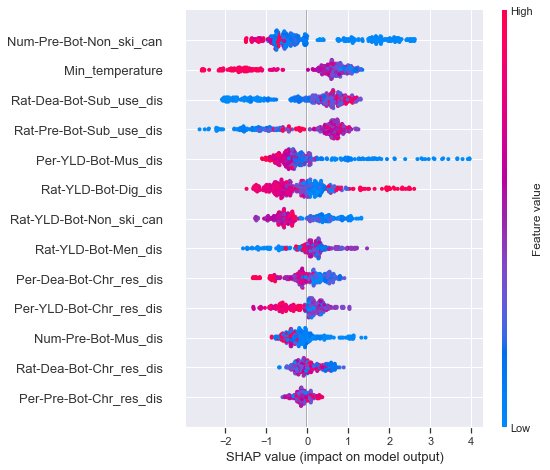

In [8]:
# Feature importance calculation
imps = xgb_grid[0].feature_importances_

# Create dummie variables and stack them with the previous dataframe
importance = pd.concat([pd.DataFrame(x_train.columns), pd.DataFrame(imps)], axis=1)
importance.columns = ["variable","importance"]

importance = importance.sort_values(by='importance', ascending=False)
print("======================================================================================")
print("Feature importance:")
print(importance)
print("======================================================================================")
print("Feature interpretation:")

# Calculate SHAP values for interpretation
shap_values = shap.TreeExplainer(xgb_grid[0]).shap_values(x_train)
shap.summary_plot(shap_values, x_train)

## Random Forest fitting

In [9]:
# vars_selected = all_vars
vars_selected = ['Num-Pre-Bot-Non_ski_can','Num-Dea-Bot-Res_inf_and_tub','Min_temperature','Per-YLD-Bot-Mus_dis','Rat-Dea-Bot-Dig_dis','Per-Dea-Bot-Men_dis','Per-Pre-Bot-Sub_use_dis','Rat-YLD-Bot-Dig_dis','Rat-Dea-Bot-Sub_use_dis','Per-Dea-Bot-Chr_res_dis','Per-YLD-Bot-Chr_res_dis','Rat-Dea-Bot-Chr_res_dis','Per-YLD-Bot-Non_ski_can','Rat-Dea-Bot-Mus_dis','Per-Dea-Bot-Sub_use_dis','Rat-YLD-Bot-Men_dis']

# Select variables
x_train = x_train_glob[vars_selected]
x_val = x_val_glob[vars_selected]
x_test = x_test_glob[vars_selected]

print("======================================================================================")
print("X Train shape:",x_train.shape)
print("Y Train shape:",y_train.shape)
print("X Validation shape:",x_val.shape)
print("Y Validation shape:",y_val.shape)
print("X Test shape:",x_test.shape)
print("Y Test shape:",y_test.shape)

X Train shape: (392, 16)
Y Train shape: (392,)
X Validation shape: (84, 16)
Y Validation shape: (84,)
X Test shape: (84, 16)
Y Test shape: (84,)


In [10]:
start_time = time.time()

# Hyperparameter optimization
if load_model:
  # Load model
  infile = open(models_path + "\\" + 'RandomForest_model.pkl','rb')
  rf_grid = pickle.load(infile)

  # Load best parameters
  infile = open(models_path + "\\" + 'best_params_RandomForest.pkl','rb')
  best_params = pickle.load(infile)
else:
  # Define function to minimize
  def param_selection_cv(params, random_state=random_state, cv=kf, X=x_train, y=y_train):

      # Use params to create new model
      model = make_pipeline( RandomForestRegressor(random_state = random_state, **params))

      # Do cross validation with the same folds
      score = -cross_val_score(model, X, y, cv=cv, scoring="neg_root_mean_squared_error", n_jobs = -1,error_score = 'raise').mean()

      return score

  # Define grid (space)
  parameters = {'n_estimators': hp.choice('n_estimators', [300])
        , 'max_depth': hp.choice('max_depth', range(3,20,2))
        , 'min_samples_split' : hp.choice('min_samples_split', range(1,10,1))
        , 'max_features' : hp.choice('max_features', range(10,x_train.shape[1],1))
        , 'bootstrap' : hp.choice('bootstrap', [True, False])
        , 'min_samples_leaf' : hp.choice('min_samples_leaf', range(1,20,1))
    }

  # Minimize function
  best = fmin(fn = param_selection_cv
            , space = parameters
            , algo = tpe.suggest
            , max_evals = 10
            , rstate = np.random.RandomState(random_state)
          )

  # Retrieve best hyperparameters
  best_params = space_eval(parameters, best)

  # Define model with best hyperparameters
  rf_grid = make_pipeline( RandomForestRegressor(random_state = random_state, **best_params))

  # Fit the model
  rf_grid.fit(x_train, y_train)

  #Save model
  with open(models_path + "\\" + 'RandomForest_model.pkl', 'wb') as pickfile:
     pickle.dump(rf_grid, pickfile)

  #Save best parameters
  with open(models_path + "\\" + 'best_params_RandomForest.pkl', 'wb') as pickfile:
     pickle.dump(best_params, pickfile)

print("======================================================================================")
print("Best parameters found: ")
print(best_params)

print("Execution: %s seconds" % (time.time() - start_time))

100%|██████████| 10/10 [00:09<00:00,  1.01it/s, best loss: 1.5414239666141882]
Best parameters found: 
{'bootstrap': True, 'max_depth': 9, 'max_features': 11, 'min_samples_leaf': 3, 'min_samples_split': 3, 'n_estimators': 300}
Execution: 10.469096422195435 seconds


In [11]:
print("======================================================================================")

# Predict values of regression with train
ypred_train = rf_grid.predict(x_train)

# Predict values of regression with validation
ypred_val = rf_grid.predict(x_val)

# Predict values of regression with test
ypred_test = rf_grid.predict(x_test)

print("Evaluating results of the regression:")
print("RMSE Score for train, validation, test: {:.5f}, {:.5f}, {:.5f}".format(rmse(y_train, ypred_train), rmse(y_val, ypred_val), rmse(y_test, ypred_test)))
print("R-squared Score for train, validation, test: {:.5f}, {:.5f}, {:.5f}".format(r2_score(y_train, ypred_train), r2_score(y_val, ypred_val), r2_score(y_test, ypred_test)))

Evaluating results of the regression:
RMSE Score for train, validation, test: 0.75943, 1.08199, 1.22340
R-squared Score for train, validation, test: 0.98290, 0.96407, 0.95611


Feature importance:
                       variable  importance
1   Num-Dea-Bot-Res_inf_and_tub    0.205164
3           Per-YLD-Bot-Mus_dis    0.196900
2               Min_temperature    0.106590
0       Num-Pre-Bot-Non_ski_can    0.089167
8       Rat-Dea-Bot-Sub_use_dis    0.048763
7           Rat-YLD-Bot-Dig_dis    0.046922
6       Per-Pre-Bot-Sub_use_dis    0.046206
10      Per-YLD-Bot-Chr_res_dis    0.042664
12      Per-YLD-Bot-Non_ski_can    0.036858
5           Per-Dea-Bot-Men_dis    0.034565
4           Rat-Dea-Bot-Dig_dis    0.031422
13          Rat-Dea-Bot-Mus_dis    0.028270
9       Per-Dea-Bot-Chr_res_dis    0.026050
11      Rat-Dea-Bot-Chr_res_dis    0.021656
15          Rat-YLD-Bot-Men_dis    0.020047
14      Per-Dea-Bot-Sub_use_dis    0.018755
Feature interpretation:


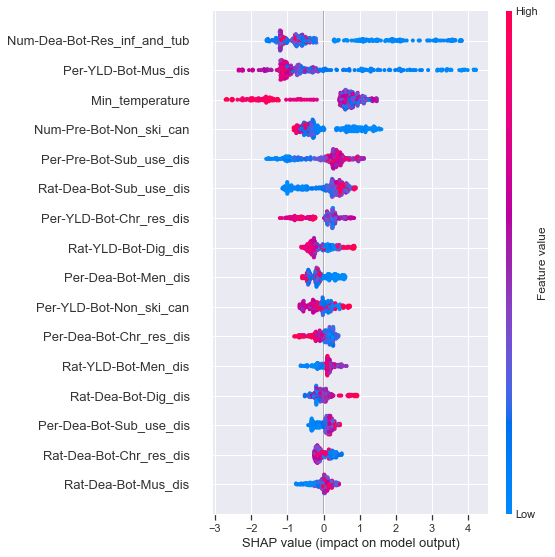

In [12]:
# Feature importance calculation
imps = rf_grid[0].feature_importances_

# Create dummie variables and stack them with the previous dataframe
importance = pd.concat([pd.DataFrame(x_train.columns), pd.DataFrame(imps)], axis=1)
importance.columns = ["variable","importance"]

importance = importance.sort_values(by='importance', ascending=False)
print("======================================================================================")
print("Feature importance:")
print(importance)
print("======================================================================================")
print("Feature interpretation:")

# Calculate SHAP values for interpretation
shap_values = shap.TreeExplainer(rf_grid[0]).shap_values(x_train)
shap.summary_plot(shap_values, x_train)

## Elastic net fitting

In [13]:
# Get quantiles for Standardization
mean = x_train_glob.mean().values
sd = x_train_glob.std().values

# Transform data - Train
x_train_glob_norm = pd.DataFrame((x_train_glob.values - mean) / (sd))
x_train_glob_norm.columns = x_train_glob.columns

# Transform data - Validation
x_val_glob_norm = pd.DataFrame((x_val_glob.values - mean) / (sd))
x_val_glob_norm.columns = x_val_glob.columns

# Transform data - Test
x_test_glob_norm = pd.DataFrame((x_test_glob.values - mean) / (sd))
x_test_glob_norm.columns = x_test_glob.columns

In [14]:
# vars_selected = all_vars
vars_selected = ['Per-Dea-Bot-Car_dis','Rat-YLD-Bot-Neo','Rat-Dea-Bot-Car_dis','Num-Dea-Bot-Car_dis','Per-YLD-Bot-Mal_ski_mel','Per-YLD-Bot-Tot_can','Num-Dea-Bot-Ski_and_sub_dis','Rat-Dea-Bot-Dig_dis','Per-Pre-Bot-Nut_def','Num-Dea-Bot-Lip_and_ora_cav_can','Per-Pre-Bot-Res_inf_and_tub','Num-Dea-Bot-Nut_def','Rat-Dea-Bot-Tot_can','Per-Dea-Bot-Dig_dis','Per-YLD-Bot-Mus_dis','Rat-Dea-Bot-Non_ski_can','Per-Dea-Bot-Dia_and_kid_dis','Rat-Dea-Bot-Mus_dis','Per-YLD-Bot-Ski_and_sub_dis','Num-Pre-Bot-Res_inf_and_tub','Per-Pre-Bot-Non_ski_can','Per-Dea-Bot-Chr_res_dis','Rat-Pre-Bot-Sub_use_dis','Mean_temperature','Per-Dea-Bot-Tra_bro_and_lun_can','Rat-Dea-Bot-Nut_def','Per-YLD-Bot-Dia_and_kid_dis','Rat-Dea-Bot-Res_inf_and_tub','Rat-Dea-Bot-Ski_and_sub_dis','Num-Dea-Bot-Mus_dis']

# Select variables
x_train = x_train_glob_norm[vars_selected]
x_val = x_val_glob_norm[vars_selected]
x_test = x_test_glob_norm[vars_selected]

print("======================================================================================")
print("X Train shape:",x_train.shape)
print("Y Train shape:",y_train.shape)
print("X Validation shape:",x_val.shape)
print("Y Validation shape:",y_val.shape)
print("X Test shape:",x_test.shape)
print("Y Test shape:",y_test.shape)

X Train shape: (392, 30)
Y Train shape: (392,)
X Validation shape: (84, 30)
Y Validation shape: (84,)
X Test shape: (84, 30)
Y Test shape: (84,)


In [15]:
start_time = time.time()

if load_model:
  # Load model
  infile = open(models_path + "\\" + 'elasticnet_model.pkl','rb')
  elasticnet_grid = pickle.load(infile)
else:
  #Define the grid to be searched in
  elasticnet = ElasticNet(random_state=random_state)

  # Create the random grid
  parameters = {'alpha':[1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 100.0]
                ,'l1_ratio': np.arange(0, 1, 0.01)}
  # Random search of parameters, using 5 fold cross validation, search across 100 different combinations, and use all available cores
  elasticnet_grid = RandomizedSearchCV(estimator = elasticnet, param_distributions = parameters, n_iter = 10, cv = num_folds, verbose=False, random_state = random_state , n_jobs = -1)
  # Fit the random search model
  elasticnet_grid.fit(x_train, y_train)

  #Save model
  with open(models_path + "\\" + 'elasticnet_model.pkl', 'wb') as pickfile:
     pickle.dump(elasticnet_grid, pickfile)
print("======================================================================================")
print("Best parameters found: ")
print(elasticnet_grid.best_params_)

print("Execution: %s seconds" % (time.time() - start_time))

Best parameters found: 
{'l1_ratio': 0.72, 'alpha': 0.001}
Execution: 0.20801472663879395 seconds


In [16]:
print("======================================================================================")

# Predict values of regression with train
ypred_train = elasticnet_grid.best_estimator_.predict(x_train)

# Predict values of regression with validation
ypred_val = elasticnet_grid.best_estimator_.predict(x_val)

# Predict values of regression with test
ypred_test = elasticnet_grid.best_estimator_.predict(x_test)

print("Evaluating results of the regression:")
print("RMSE Score for train, validation, test: {:.5f}, {:.5f}, {:.5f}".format(rmse(y_train, ypred_train), rmse(y_val, ypred_val), rmse(y_test, ypred_test)))
print("R-squared Score for train, validation, test: {:.5f}, {:.5f}, {:.5f}".format(r2_score(y_train, ypred_train), r2_score(y_val, ypred_val), r2_score(y_test, ypred_test)))

Evaluating results of the regression:
RMSE Score for train, validation, test: 1.25798, 1.18291, 1.29035
R-squared Score for train, validation, test: 0.95307, 0.95706, 0.95118


In [17]:
# Feature importance calculation
imps = permutation_importance(elasticnet_grid.best_estimator_, x_train, y_train)

# Create dummie variables and stack them with the previous dataframe
importance = pd.concat([pd.DataFrame(x_train.columns), pd.DataFrame(imps.importances_mean)], axis=1)
importance.columns = ["variable","importance"]

importance = importance.sort_values(by='importance', ascending=False)
print("======================================================================================")
print("Feature importance:")
print(importance)

Feature importance:
                           variable  importance
0               Per-Dea-Bot-Car_dis    3.876022
1                   Rat-YLD-Bot-Neo    1.701618
2               Rat-Dea-Bot-Car_dis    1.461338
4           Per-YLD-Bot-Mal_ski_mel    0.954104
5               Per-YLD-Bot-Tot_can    0.776208
3               Num-Dea-Bot-Car_dis    0.664611
8               Per-Pre-Bot-Nut_def    0.527564
7               Rat-Dea-Bot-Dig_dis    0.516373
10      Per-Pre-Bot-Res_inf_and_tub    0.427647
6       Num-Dea-Bot-Ski_and_sub_dis    0.414052
9   Num-Dea-Bot-Lip_and_ora_cav_can    0.363512
11              Num-Dea-Bot-Nut_def    0.310674
21          Per-Dea-Bot-Chr_res_dis    0.242417
12              Rat-Dea-Bot-Tot_can    0.220396
14              Per-YLD-Bot-Mus_dis    0.213302
17              Rat-Dea-Bot-Mus_dis    0.180142
29              Num-Dea-Bot-Mus_dis    0.145493
18      Per-YLD-Bot-Ski_and_sub_dis    0.143964
15          Rat-Dea-Bot-Non_ski_can    0.141397
13              Per-